In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sys
import os
import string
from models import lstm_model
from losses import *
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re
# import literal_eval

2022-10-03 13:11:23.742328: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [1]:
!ls ../data/processed/

english_luganda.csv   processed_1.csv  processed_5
english_luganda2.csv  processed_2.csv  processed_5.csv
metadata.csv	      processed_3.csv  processed_5_with_all_sentences.csv
metadata_@40000.csv   processed_4.csv  processed_6.csv


In [3]:
new_data = pd.read_csv('../data/processed/english_luganda2.csv')

In [4]:
train_data=new_data[new_data.folds.isin([0,1,2])].reset_index(drop=True)
# train_data=shuffle(train_data).reset_index().drop(columns='index')
val_data = new_data[new_data.folds==3].reset_index().drop(columns='index')
test_data = new_data[new_data.folds==4].reset_index().drop(columns='index')

In [5]:
train_data

,text,folds,english,luganda
0,government constructed better health centers r...,0,1,0
1,company celebrated twenty years existence last...,0,1,0
2,many people have lost their lives sexually tra...,0,1,0
3,civil servants receive their pension fund upon...,0,1,0
4,teachers also among civil servants,0,1,0
...,...,...,...,...
32146,biki ebyetaagisa okusobola okukola omulimu oku...,2,0,1
32147,gavumenti ekoze enteekateeka ennungi abantu ok...,2,0,1
32148,abantu balina okulya okunywa,2,0,1
32149,emboozi ejja kweyongela maaso,2,0,1


In [6]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  remove_numbers = tf.strings.regex_replace(lowercase,"\d+","")
  stripped_html = tf.strings.regex_replace(remove_numbers, '<br />', ' ')

  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '').numpy().decode("utf-8")

In [7]:
train_data.text=train_data.text.apply(custom_standardization)

2022-10-03 13:11:25.760411: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-03 13:11:25.761837: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-03 13:11:27.773817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 13:11:27.774604: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-10-03 13:11:27.774640: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-10-03 13:11:27.776785: I tensorflow/stream_executor/platform/default/dso_lo

In [8]:
train_data

,text,folds,english,luganda
0,government constructed better health centers r...,0,1,0
1,company celebrated twenty years existence last...,0,1,0
2,many people have lost their lives sexually tra...,0,1,0
3,civil servants receive their pension fund upon...,0,1,0
4,teachers also among civil servants,0,1,0
...,...,...,...,...
32146,biki ebyetaagisa okusobola okukola omulimu oku...,2,0,1
32147,gavumenti ekoze enteekateeka ennungi abantu ok...,2,0,1
32148,abantu balina okulya okunywa,2,0,1
32149,emboozi ejja kweyongela maaso,2,0,1


In [9]:
# train_corpus = ' '.join(train_data.text.values.tolist())
unique_word_count = Counter()
for i in train_data.text.values:
    for word in i.split():
        unique_word_count[word]+=1

In [10]:
len(unique_word_count)

32156

In [11]:
word_counts=list(unique_word_count.values())
words=list(unique_word_count.keys())
indexes = sorted(range(len(word_counts)), key=lambda k: word_counts[k])
sorted_words=np.array(words)[indexes]
sorted_word_counts=np.array(word_counts)[indexes]

In [12]:
word_number=list(Counter(sorted_word_counts).keys())
word_number = [str(x) for x in word_number]
word_number_count=list(Counter(sorted_word_counts).values())

Text(0, 0.5, 'Counts')

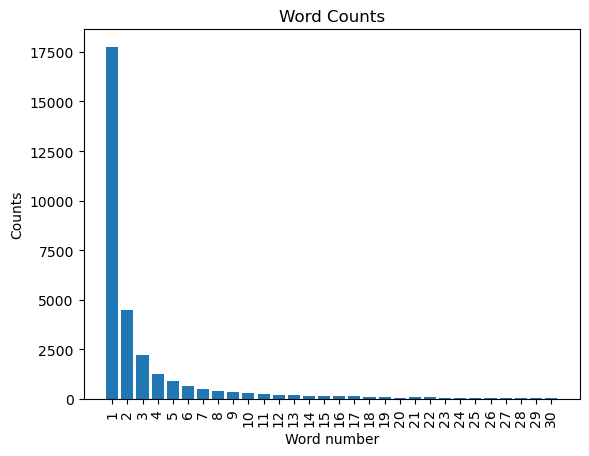

In [13]:
plt.bar(word_number[:30],word_number_count[:30])
plt.xticks(rotation=90)
plt.title("Word Counts")
plt.xlabel("Word number")
plt.ylabel("Counts")

In [14]:
len(unique_word_count)

32156

In [15]:
tokenizer = Tokenizer(num_words=len(unique_word_count))
tokenizer.fit_on_texts(train_data.text)

In [16]:
max_length=8
train_sequences=tokenizer.texts_to_sequences(train_data.text)
train_padded_sequences = pad_sequences(train_sequences,maxlen=max_length,padding='post',truncating='post')

val_sequences=tokenizer.texts_to_sequences(val_data.text)
val_padded_sequences = pad_sequences(val_sequences,maxlen=max_length,padding='post',truncating='post')

test_sequences=tokenizer.texts_to_sequences(test_data.text)
test_padded_sequences = pad_sequences(test_sequences,maxlen=max_length,padding='post',truncating='post')

In [17]:
train_data.iloc[:,2:].sum()

english    15157
luganda    16994
dtype: int64

In [18]:
!ls ..

__pycache__  deployment_models	losses.py  train_el.py	   weights_bi
config.py    eng-lug		models.py  train_model.py  weights_bi2
data	     eng-lug_2		notebooks  weights


In [20]:
import json

tokenizer.word_index
with open("../metatxt.txt",'w+') as file:
    for key,value in tokenizer.word_index.items():
#         print("{} {}".format(key,value))
        file.write("{} {}\n".format(key,value))

In [21]:
!pip install tflite-support-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 20.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.3/213.3 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 72.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires flatbuffers~=1.12.0, but you have flatbuffers 2.0 which is incompatible.
tensorflow 2.4.1 requires gast==0.3.3, but you have gast 0.4.0 which is incompatible.
tensorflow 2.4.1 requires grpcio~=1.32.0, but you have grpcio 1.42.0 which is incompatible.
tensorflow 2.4.1 requires numpy~=1.19.2, but you have numpy 1.23.3 which is incompatible.
tensorflow 2.4.1 requires six~=1.15.0, but y

In [23]:
from tflite_support.metadata_writers import nl_classifier
from tflite_support.metadata_writers import metadata_info
from tflite_support.metadata_writers import writer_utils

In [38]:
# def custom_standardization(input_data):
#   lowercase = tf.strings.lower(input_data)
#   remove_numbers = tf.strings.regex_replace(lowercase,"\d+","")
#   stripped_html = tf.strings.regex_replace(remove_numbers, '<br />', ' ')

#   return tf.strings.regex_replace(stripped_html,
#                                   '[%s]' % re.escape(string.punctuation),
#                                   '')

In [39]:
# vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
#     standardize=custom_standardization,
#     max_tokens=len(unique_word_count),
#     output_mode='int',
#     output_sequence_length=max_length)

In [17]:
# vectorize_layer.adapt(train_data.text.values)

In [40]:
# vectorize_layer(train_data.text.values)

In [24]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
                    filepath='/home/g007markphillip/language_classification2/weights_bi2/cp-{epoch:04d}.ckpt',
                    save_weights_only=True,
                    save_freq='epoch')

w_array = np.ones([2,2])
w_array[1,0]=30

model = lstm_model(embed_dim=32,
                   max_length=8,
                   count=len(unique_word_count),
#                    vectorize_layer=vectorize_layer
                  )
optimizer = tf.keras.optimizers.Adam(1e-5)

loss = WeightedCategoricalCrossentropy(w_array)

model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])
# model.build((None,max_length))
# model.summary()
# model.fit(tf.convert_to_tensor(train_padded_sequences), train_data[['english','luganda']].values,
#       validation_data=(val_padded_sequences ,val_data[['english','luganda']].values),
#       epochs=100,
#       batch_size=128,
#       callbacks=[cp_callback]
#          )

model.fit(train_padded_sequences, train_data[['english','luganda']].values,
      validation_data=(val_padded_sequences ,val_data[['english','luganda']].values),
      epochs=100,
      batch_size=128,
      callbacks=[cp_callback]
         )

2022-10-03 13:23:38.271430: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-03 13:23:38.287180: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-10-03 13:23:40.205887: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-10-03 13:23:40.890290: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


252/252 [==============================] - 8s 13ms/step - loss: 4.5099 - accuracy: 0.5251 - val_loss: 1.5669 - val_accuracy: 0.5697
Epoch 2/100
252/252 [==============================] - 3s 11ms/step - loss: 1.6935 - accuracy: 0.5800 - val_loss: 0.9463 - val_accuracy: 0.5807
Epoch 3/100
252/252 [==============================] - 3s 11ms/step - loss: 1.0596 - accuracy: 0.6019 - val_loss: 0.7798 - val_accuracy: 0.5968
Epoch 4/100
252/252 [==============================] - 3s 10ms/step - loss: 0.8843 - accuracy: 0.6252 - val_loss: 0.7449 - val_accuracy: 0.6231
Epoch 5/100
252/252 [==============================] - 3s 11ms/step - loss: 0.8097 - accuracy: 0.6638 - val_loss: 0.7286 - val_accuracy: 0.6563
Epoch 6/100
252/252 [==============================] - 3s 11ms/step - loss: 0.7533 - accuracy: 0.7090 - val_loss: 0.7197 - val_accuracy: 0.6986
Epoch 7/100
252/252 [==============================] - 3s 11ms/step - loss: 0.7331 - accuracy: 0.7585 - val_loss: 0.7086 - val_accuracy: 0.7467
Epoc

In [25]:
# tf.train.latest_checkpoint('/home/g007markphillip/language_classification/weights/')
# model.load_weights('/home/g007markphillip/language_classification2/weights_bi2/cp-0033.ckpt')


In [26]:
pred_values=model.predict(test_padded_sequences)
# pred_values = model.predict(test_data.text.values)
pred_values = np.argmax(pred_values,1).astype('int')
true_values=test_data[['english','luganda']].values
true_values=np.argmax(true_values,1).astype('int')

In [27]:
pred_values

array([0, 0, 0, ..., 1, 1, 1])

In [28]:
!ls ..

__pycache__  deployment_models	losses.py    notebooks	     weights
config.py    eng-lug		metatxt.txt  train_el.py     weights_bi
data	     eng-lug_2		models.py    train_model.py  weights_bi2


In [32]:
model.save('../eng-lug_2')

2022-10-03 14:01:58.741532: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../eng-lug_2/assets


INFO:tensorflow:Assets written to: ../eng-lug_2/assets


In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(true_values,pred_values)

cm_df=pd.DataFrame(cm,index=['english','luganda'],\
                   columns=['english','luganda'])

Text(0.5, 23.52222222222222, 'Y_PRED')

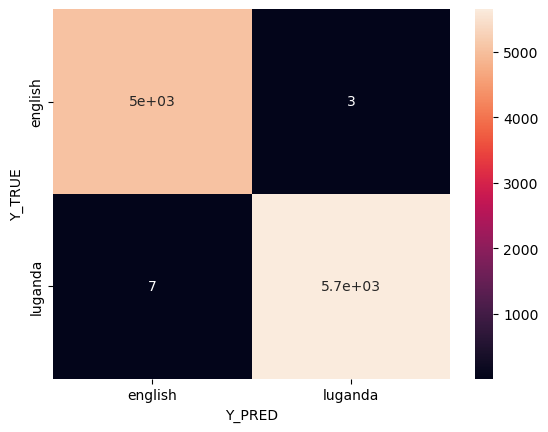

In [31]:
import matplotlib.pyplot as plt
sns.heatmap(cm_df,annot=True)
plt.ylabel('Y_TRUE')
plt.xlabel('Y_PRED')

In [34]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model.
# with open('../model.tflite', 'wb') as f:
#     f.write(tflite_model)

In [35]:
NLClassifierWriter = nl_classifier.MetadataWriter
_MODEL_PATH = "../model.tflite"
# Task Library expects label files and vocab files that are in the same formats
# as the ones below.
_LABEL_FILE = "../labels.txt"
_VOCAB_FILE = "../vocab.txt"
# NLClassifier supports tokenize input string using the regex tokenizer. See
# more details about how to set up RegexTokenizer below:
# https://github.com/tensorflow/tflite-support/blob/master/tensorflow_lite_support/metadata/python/metadata_writers/metadata_info.py#L130
_DELIM_REGEX_PATTERN = r"[^\w\']+"
_SAVE_TO_PATH = "../moview_review_metadata.tflite"

# Create the metadata writer.
writer = nl_classifier.MetadataWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH),
    metadata_info.RegexTokenizerMd(_DELIM_REGEX_PATTERN, _VOCAB_FILE),
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "NLClassifier",
  "description": "Classify the input text into a set of known categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "input_text",
          "description": "Embedding vectors representing the input text to be classified.",
          "content": {
            "content_properties_type": "FeatureProperties",
            "content_properties": {
            }
          },
          "process_units": [
            {
              "options_type": "RegexTokenizerOptions",
              "options": {
                "delim_regex_pattern": "[^\\w\\']+",
                "vocab_file": [
                  {
                    "name": "../vocab.txt",
                    "description": "Vocabulary file to convert natural language words to embedding vectors.",
                    "type": "VOCABULARY"
                  }
                ]
              }
            }
          ],
          "stats": {
          }
        }
   

Text(0.5, 23.52222222222222, 'Y_PRED')

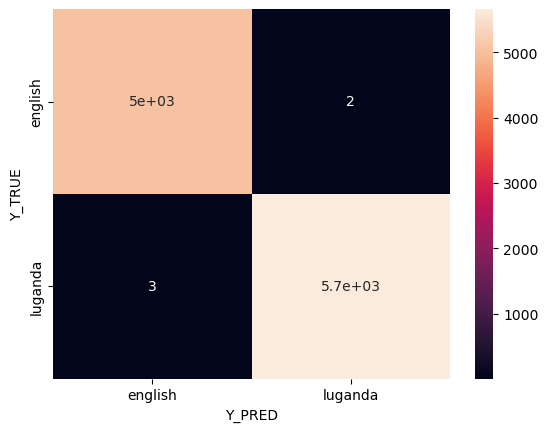

In [37]:
import matplotlib.pyplot as plt
sns.heatmap(cm_df,annot=True)
plt.ylabel('Y_TRUE')
plt.xlabel('Y_PRED')

In [40]:
from sklearn.metrics import classification_report
print(classification_report(true_values,pred_values))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5052
           1       1.00      1.00      1.00      5664

    accuracy                           1.00     10716
   macro avg       1.00      1.00      1.00     10716
weighted avg       1.00      1.00      1.00     10716



In [ ]:
import io
out_v = io.open('vectors_test_multi.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata_test_multi.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    vec = embeddings[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
text=np.array(['lakini ambacho zaidi ujumbe wachezaji wawili'])
text = tokenizer.texts_to_sequences(text)
text = pad_sequences(text,maxlen=max_length,padding='post',truncating='post')
prediction = model.predict(text)

prediction = np.argmax(prediction,1).astype('int').tolist()
inverse_classes[prediction[0]]

In [ ]:
import gradio as gr
# dict_={value:key for key,value in classes.items()}


def function_(input_):
#     text=to_lower(remove_punctuation(input_))
    text=np.array([input_])
    text = tokenizer.texts_to_sequences(text)
    text = pad_sequences(text,maxlen=max_length,padding='post',truncating='post')
    prediction = model.predict(text)
   
    prediction = np.argmax(prediction,1).astype('int').tolist()
    return inverse_classes[prediction[0]]


ui = gr.Interface(
    function_,
    title="Language Classification",
    description='Enter Text',
    inputs=gr.inputs.Textbox(lines=5),
    outputs=gr.outputs.Textbox(label='Language')
)
ui.launch(share=True)

In [ ]:
test_data[test_data.luganda==1]

In [ ]:
test_data=test_data[['text','english','acholi','luganda','lumasaba','runyankore','swahili']]

In [ ]:
false_pred_index=np.where((true_values!=pred_values)==True,)

In [ ]:
test_data.iloc[false_pred_index[0]]

In [ ]:
false_pred_classes=pred_values[true_values!=pred_values]

In [ ]:
false_pred_classes

In [ ]:
test_data[true_values!=pred_values]

In [ ]:
true_values

In [ ]:
test_data

In [ ]:
!ls ../data/processed

In [ ]:
test_meta=pd.read_csv('../data/processed/metadata_@40000.csv')

In [ ]:
classes_df=pd.get_dummies(test_meta['classes'])

In [ ]:
test_meta=pd.concat([test_meta['text'],classes_df],axis=1)

In [ ]:
test_meta=test_meta.drop(columns=['luo'])

In [ ]:
test_meta[['acholi','english','lumasaba','runyankore']]=np.zeros([len(test_meta),4]).astype('int')

In [ ]:
test_meta.iloc[:,1:].sum()

In [ ]:
test_meta_sequences=tokenizer.texts_to_sequences(test_meta.text)
test_meta_padded_sequences = pad_sequences(test_meta_sequences,maxlen=max_length,padding='post',truncating='post')

In [ ]:
import numpy as np
pred_meta_values=model.predict(test_meta_padded_sequences)
pred_meta_values = np.argmax(pred_meta_values,1).astype('int')
true_meta_values=test_meta[['english','acholi','luganda','lumasaba','runyankore','swahili']].values
true_meta_values=np.argmax(true_meta_values,1).astype('int')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(true_meta_values,pred_meta_values)

cm_df=pd.DataFrame(cm,index=['english','acholi','luganda','lumasaba','runyankore','swahili'],\
                   columns=['english','acholi','luganda','lumasaba','runyankore','swahili'])

In [ ]:
import matplotlib.pyplot as plt
sns.heatmap(cm_df,annot=True)
plt.ylabel('Y_TRUE')
plt.xlabel('Y_PRED')

In [ ]:
train_corpus = ' '.join(train_data.text.values.tolist())
train_corpus_list=train_corpus.split()

test_corpus = ' '.join(test_meta.text.values.tolist())
test_corpus_list=test_corpus.split()

In [ ]:
from collections import Counter

In [ ]:
len(Counter(train_corpus_list))

In [ ]:
len(Counter(test_corpus_list))

In [ ]:
len(set(train_corpus_list) &set(test_corpus_list))

In [ ]:
len(set(test_corpus_list)-(set(train_corpus_list).intersection(test_corpus_list)))

In [ ]:
len(train_data)

In [2]:
from typing import List

In [10]:
def h(g:list[str]):
    print(g)

In [11]:
h([1,2,4.6])

[1, 2, 4.6]


In [12]:
[1,2,3,4][:-1]

[1, 2, 3]